In [ ]:
from PIL import Image
import csv
import numpy as np
import os
import pandas as pd
import cv2
import json
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, ELU, Lambda
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#### The goals / steps of this project are the following:
* Use the simulator to collect data of good driving behavior
* Design, train and validate a model that predicts a steering angle from image data
* Use the model to drive the vehicle autonomously around the first track in the simulator. The vehicle should remain on the road for an entire loop around the track.
* Summarize the results with a written report

### This project has been a challenging one - some of the well established NN models (vgg,NVIDIA, comma.ai) failed to produce good results. In the end, I've followed what has been suggested by the udacity mentor.   

### I will be using the udacity data for trainning the model, while for the validation and test I will use data recorded on the first track and second track, respectively

In [2]:
img_dir = "./data/train/center/"
images = [img_dir+ f for f in os.listdir(img_dir)]
X_train = []
for image in images:
    img1 = cv2.imread(image)
    img = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
    s=img.shape[0]*img.shape[1]*img.shape[2]
    img_wide = img.reshape(s)
    #print(new_img)
    X_train.append(img_wide)   
X_train = np.array(X_train) 

### I will not use right\left cams but just the center ones. However, for the center I will apply different image transformation 

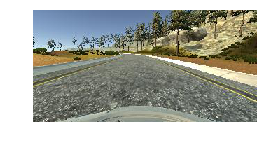

In [3]:
plt.figure(figsize=(4, 4))
plt.axis('off')
ind = np.random.randint(0, len(X_train))
img=X_train[ind,:].reshape(img.shape[0],img.shape[1],img.shape[2]) 
_ = plt.imshow(img)
plt.show()

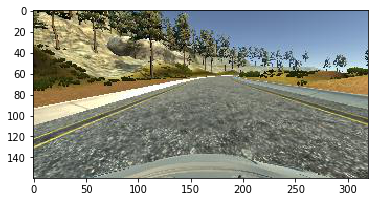

In [4]:
image_flipped = np.fliplr(img)
_ = plt.imshow(image_flipped)
plt.show()

In [5]:
names = ['center', 'steering', 'throttle', 'brake', 'speed']
valid_data = pd.read_csv( './data/valid/driving_log.csv', names=names)
test_data = pd.read_csv('./data/test/driving_log.csv', names=names)

In [6]:
train_file = pd.read_csv('./data/train_final/driving_log.csv')
train_nonzero = train_file[train_file.steering != 0]
train_zero = (train_file[train_file.steering == 0]).sample(frac=1)

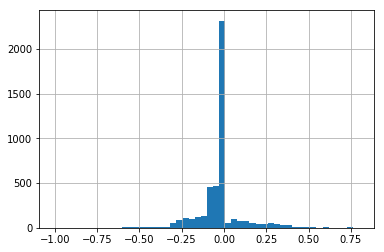

In [7]:
train_data = pd.concat([train_nonzero, train_zero], ignore_index=True)
train_data.steering.hist(bins=50)

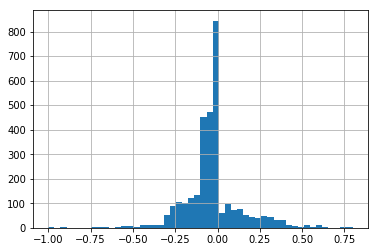

In [8]:
train_zero = (train_file[train_file.steering == 0]).sample(frac=0.2)
train_data = pd.concat([train_nonzero, train_zero], ignore_index=True)
train_data.steering.hist(bins=50)

In [21]:
ind = np.random.randint(0, len(train_data))
train_data.center[ind]

'/Users/ramona/Documents/CarND/proj3/data/train/IMG/center_2016_11_22_15_02_15_041.jpg'

### Training data is very unbalanced -- from 8000+ rows more than half is about straight driving, where steering angle is 0. To solve this, I keep only 20% of zero-angle data:

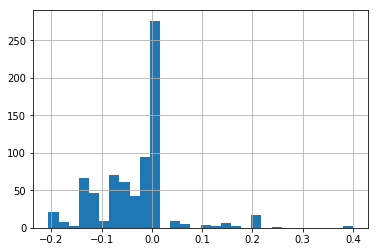

In [10]:
valid_data.steering.hist(bins=30)

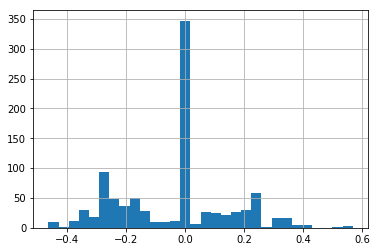

In [11]:
test_data.steering.hist(bins=30)

#### The training set data for the steering is centered arond zero value with what seams to be a more normal distribution of the angles between -0.5 and 0.5 degrees. For the validation and testing test, the values are skewed and with the majority being still zero value

### Plot of the validation and test data as a time series.

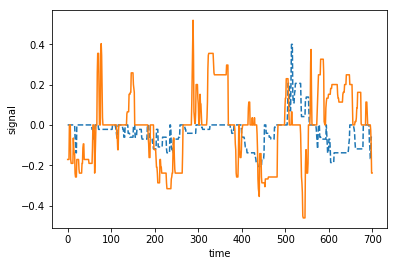

In [12]:
len_plt = 700
steer_valid = np.array(valid_data.steering,dtype=np.float32)
steer_test = np.array(test_data.steering,dtype=np.float32)
t_s = np.arange(len(steer_valid))
y_valid = steer_valid
y_test = steer_test

plt.plot(t_s[0:len_plt],y_valid[0:len_plt],'--',t_s[0:len_plt],y_test[0:len_plt]);
plt.xlabel('time')
plt.ylabel('signal')
#plt.ylim(-0.5,0.5);

#### Image transformation: flipping, brightness and translation augmentations

In [13]:
def flipped_image(img, y):
    img = cv2.flip(img, 1)
    return img, -y


def brightned_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    random_bright = .25 + np.random.uniform()
    img[:,:,2] = img[:,:,2] * random_bright
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    return img


def translated_image(img, y, trans_range):
    rows, cols, _ = img.shape
    tr_x = trans_range * np.random.uniform() - trans_range/2
    y = y + tr_x/trans_range * 2 *.4
    tr_y = 10 * np.random.uniform() - 10/2
    Trans_M = np.float32([[1,0, tr_x], [0,1, tr_y]])
    img = cv2.warpAffine(img, Trans_M, (cols, rows))
    return img, y


def image_augmentation(img, y):
    if np.random.uniform() < 0.5:
        img, y = flipped_image(img, y)
    img = brightned_image (img)
    img, y = translated_image(img, y, 100)
    return img, y


def image_transformation(img):
    img = img[60:-20,:,:]
    img = cv2.resize(img, (input_shape[1], input_shape[0]), interpolation=cv2.INTER_AREA)
    return img

In [14]:
input_shape = (64, 64, 3)

#### For each image using only the steering angle associated with it

In [15]:
def get_image_steering_train(row, folder):
    imgpath = row.center.values[0]
    imgpath = imgpath[imgpath.find('IMG'):]
    #print(folder + imgpath)
    img = cv2.imread(folder + imgpath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    steering = row.steering.values[0]
    return img, steering


def get_img_and_steering(row, folder):
    imgpath = row.center
    imgpath = imgpath[imgpath.find('IMG'):]
    img = cv2.imread(folder + imgpath)
    #print(folder+imgpatg)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    steering = row.steering
    return img, steering


### Generators
#### Training data - udacity

In [16]:
def train_data_generator(batch_size):
    while True:
        X = np.zeros((batch_size, *input_shape), dtype=np.float32)
        y = np.zeros((batch_size,), dtype=np.float32)
        for idx in range(batch_size):
            row = train_data.sample()
            img, steering = get_image_steering_train(row, './data/train_final/')
            img, steering = image_augmentation(img, steering)
            img = image_transformation(img)
            X[idx], y[idx] = img, steering
        yield X, y

#### Validation data - recorded by myself on the same track as udacity data

In [17]:
def valid_data_generator(batch_size):
    seq_idx = 0
    while True:
        X = np.zeros((batch_size, *input_shape), dtype=np.float32)
        y = np.zeros((batch_size,), dtype=np.float32)
        for idx in range(batch_size):
            row = valid_data.iloc[seq_idx]
            img, steering = get_img_and_steering(row, './data/valid/')
            img = image_transformation(img)
            X[idx], y[idx] = img, steering
            
            seq_idx += 1
            if seq_idx == len(valid_data):
                seq_idx = 0
        yield X, y

#### Test data - the other track recorded images

In [18]:
def test_data_generator(batch_size):
    seq_idx = 0
    while True:
        X = np.zeros((batch_size, *input_shape), dtype=np.float32)
        y = np.zeros((batch_size,), dtype=np.float32)
        for idx in range(batch_size):
            row = test_data.iloc[seq_idx]
            img, steering = get_img_and_steering(row, './data/test/')
            img = image_transformation(img)
            X[idx], y[idx] = img, steering
            
            seq_idx += 1
            if seq_idx == len(test_data):
                seq_idx = 0
        yield X, y

#### As many suggested on slack and medium, Vivek Yadav's https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.zgnmu27j9 solution for the model seams to be working for majority


In [19]:
def CNN_model():
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1., input_shape=input_shape))
    model.add(Convolution2D(3,1,1,  border_mode='valid', name='conv0', init='he_normal'))
    model.add(Convolution2D(32,3,3, border_mode='valid', name='conv1', init='he_normal'))
    model.add(ELU())
    model.add(Convolution2D(32,3,3, border_mode='valid', name='conv2', init='he_normal'))
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    
    model.add(Convolution2D(64,3,3, border_mode='valid', name='conv3', init='he_normal'))
    model.add(ELU())
    model.add(Convolution2D(64,3,3, border_mode='valid', name='conv4', init='he_normal'))
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    
    model.add(Convolution2D(128,3,3, border_mode='valid', name='conv5', init='he_normal'))
    model.add(ELU())
    model.add(Convolution2D(128,3,3, border_mode='valid', name='conv6', init='he_normal'))
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(512,name='hidden1', init='he_normal'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Dense(64,name='hidden2', init='he_normal'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Dense(16,name='hidden3',init='he_normal'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Dense(1, name='output', init='he_normal'))
    model.compile(optimizer="adam", loss="mse")
    return model

 #### The first layer is 3 1X1 filters,  followed by 3 convolutional blocks each comprised of 32, 64 and 128 filters of size 3X3. These convolution layers were followed by 3 fully connected layers. All the convolution blocks and the 2 following fully connected layers had exponential relu (ELU) as activation function
 
 #### The lambda layer ensures that the model will normalize the input images
 
 
 

#### I've used the Adam optimizer with the default learning rate. I've played with multiple paramater values, inlcuding the one suggested by Vivek (adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)), however the results didn't improve

In [20]:
model = CNN_model()
model.fit_generator(
    train_data_generator(50),
    samples_per_epoch=20000,
    nb_epoch=10,
    validation_data=valid_data_generator(250),
    nb_val_samples=750,
    callbacks=[ModelCheckpoint(filepath="best_valid_score.h5", verbose=1, save_best_only=True)]
)

Epoch 1/10
20000/20000 [==============================] - 707s - loss: 5.4954 - val_loss: 27.1331
Epoch 2/10
20000/20000 [==============================] - 622s - loss: 1.3535 - val_loss: 0.1270
Epoch 3/10
20000/20000 [==============================] - 627s - loss: 1.1130 - val_loss: 0.0452
Epoch 4/10
20000/20000 [==============================] - 596s - loss: 0.9250 - val_loss: 0.0474
Epoch 5/10
20000/20000 [==============================] - 597s - loss: 0.7631 - val_loss: 0.0284
Epoch 6/10
20000/20000 [==============================] - 669s - loss: 0.6251 - val_loss: 0.0208
Epoch 7/10
20000/20000 [==============================] - 604s - loss: 0.5201 - val_loss: 0.0345
Epoch 8/10
20000/20000 [==============================] - 611s - loss: 0.4149 - val_loss: 0.0291
Epoch 9/10
20000/20000 [==============================] - 608s - loss: 0.3411 - val_loss: 0.0188
Epoch 10/10
20000/20000 [==============================] - 609s - loss: 0.2728 - val_loss: 0.0216


#### Even though large epoch size and training with more data results in better performance, in this case any time I got beyond 10 epochs, the car simply drove off the track. 


In [22]:
import json
with open('model.json', 'w') as f:
    f.write(model.to_json())
model.save_weights('model.h5')

#### Check the performance for some samples in the test data

In [23]:
folder='./data/test/'
for i in range(10):
    row = test_data.sample()
    imgpath = row.center.values[0]
    imgpath = imgpath[imgpath.find('IMG'):]
    img = cv2.imread(folder + imgpath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = image_transformation(img)
    print(row.steering.values[0], model.predict(np.expand_dims(img, axis=0))[0])

0.3549278 [ 0.1018593]
-0.1906421 [ 0.09972793]
0.0 [ 0.1023131]
-0.2582892 [ 0.09932402]
0.1616505 [ 0.10200685]
0.0 [ 0.09974796]
-0.2389614 [ 0.09465021]
-0.267953 [ 0.09918594]
0.2486252 [ 0.10301289]
0.0 [ 0.10225224]


#### The test data shows pretty good performance, while the validation is even closer to what the steering angle should be. However, the cumulative effect of this error is being proeminently seen after just few seconds of driving 

In [24]:
folder='./data/valid/'
for i in range(10):
    row = valid_data.sample()
    imgpath = row.center.values[0]
    imgpath = imgpath[imgpath.find('IMG'):]
    img = cv2.imread(folder + imgpath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = image_transformation(img)
    print(row.steering.values[0], model.predict(np.expand_dims(img, axis=0))[0])

0.0 [ 0.10295033]
-0.06077444 [ 0.09708244]
-0.02204349 [ 0.10422111]
0.0 [ 0.08977002]
0.1575641 [ 0.08828929]
0.0 [ 0.08924568]
-0.04140897 [ 0.0900833]
-0.1866501 [ 0.09291941]
0.0 [ 0.08621067]
-0.04140897 [ 0.10190761]
